## VGG 16 Model (Transfer Learning)

### Importing Libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img , img_to_array
#import tensorflow.keras.applications.VGG16
from tensorflow.keras import layers 
from tensorflow.keras import Model
import numpy as np

### Setting Paths

In [2]:
base_dir = 'D:/DataSets/Image Scene Classificaon Dataset/'

train_dir = os.path.join(base_dir,'train/')
test_dir = os.path.join(base_dir,'test/')

Building_dir = os.path.join(train_dir,'buildings/')
Mountain_dir = os.path.join(train_dir,'mountain/')
Forest_dir = os.path.join(train_dir,'forest/')
Glacier_dir = os.path.join(train_dir,'glacier/')
Street_dir = os.path.join(train_dir,'street/')
Sea_dir = os.path.join(train_dir,'sea/')

buildings_files = os.listdir(Building_dir)
mountain_files = os.listdir(Mountain_dir)
forest_files = os.listdir(Forest_dir)
glacier_files = os.listdir(Glacier_dir)
street_files = os.listdir(Street_dir)
sea_files = os.listdir(Sea_dir)

### Displaying some Imgs

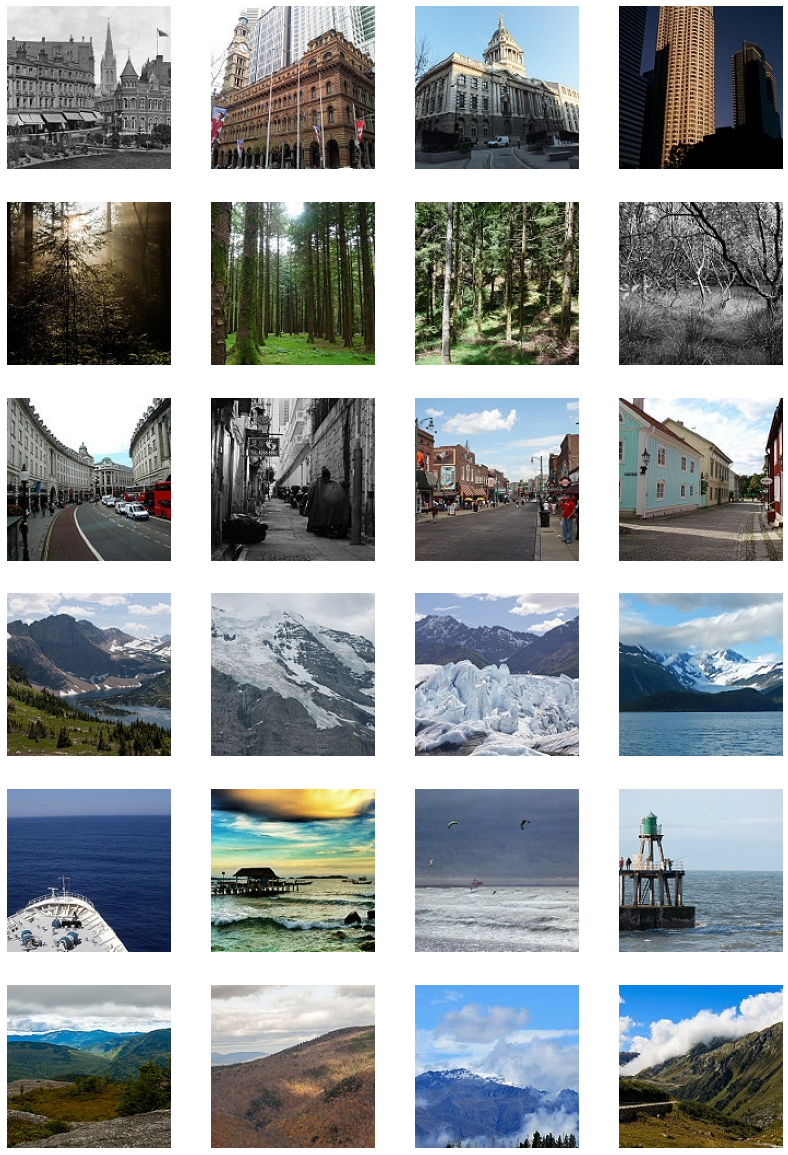

In [3]:
# Set up matplotlib fig, and size it to fit 4x4 pics
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 6
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols * 3.5, nrows * 3.5)

building_imgs = [os.path.join(Building_dir , fname) 
                for fname in buildings_files[0:4]]
mountain_imgs = [os.path.join(Mountain_dir, fname) 
                for fname in mountain_files[0:4]]
forest_imgs = [os.path.join(Forest_dir, fname) 
                for fname in forest_files[0:4]]
street_imgs = [os.path.join(Street_dir, fname) 
                for fname in street_files[0:4]]
sea_imgs = [os.path.join(Sea_dir, fname) 
                for fname in sea_files[0:4]]
glacier_imgs = [os.path.join(Glacier_dir, fname) 
                for fname in glacier_files[0:4]]


for i, img_path in enumerate(building_imgs+forest_imgs+street_imgs+glacier_imgs+sea_imgs+mountain_imgs):
    
      sp = plt.subplot(nrows, ncols, i+1)
      sp.axis('Off') # Don't show axes (or gridlines)

      image = mpimg.imread(img_path)
      plt.imshow(image)

plt.show()

### Creating Train & Validation Datagen

In [4]:
train_generator = ImageDataGenerator(rescale = 1./255 , validation_split = 0.3)
#test_generator = ImageDataGenerator(rescale = 1./255)

train_datagen = train_generator.flow_from_directory(
    train_dir,  
    target_size=(150,150), 
    batch_size= 12,
    class_mode='categorical',
    subset='training') 

valid_datagen = train_generator.flow_from_directory(
    train_dir,  
    target_size=(150,150), 
    batch_size= 4,
    class_mode='categorical',
    subset='validation') 


# test_datagen = test_generator.flow_from_directory(
#     test_dir,  
#     target_size=(150,150), 
#     batch_size= 16,
#     class_mode='categorical') 

Found 9541 images belonging to 6 classes.
Found 4084 images belonging to 6 classes.


### Defining Calllbacks

In [5]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.83 and logs.get('accuracy')>0.93):
            self.model.stop_training = True
            print("\nReached 90% accuracy so cancelling training!")   
            
callbacks = myCallback() 

### Creating & Compiling the model

In [6]:
pt_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(150, 150, 3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

for layer in pt_model.layers:
    layer.trainable = False
    
last_layer = pt_model.get_layer('block4_pool')
last_output = last_layer.output

x = layers.Flatten()(last_output)
x = layers.Dense(512 , activation = 'relu')(x)
x = layers.Dense(6 , activation = 'softmax')(x)

model = Model(pt_model.input , x)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

### Training the model

In [8]:
history = model.fit(train_datagen,epochs = 8,callbacks = [callbacks],validation_data = valid_datagen)

Epoch 1/8
796/796 [==============================] - 96s 120ms/step - loss: 1.7882 - accuracy: 0.7984 - val_loss: 0.4483 - val_accuracy: 0.8582
Epoch 2/8
796/796 [==============================] - 93s 117ms/step - loss: 0.2680 - accuracy: 0.9060 - val_loss: 0.8257 - val_accuracy: 0.7973
Epoch 3/8
796/796 [==============================] - ETA: 0s - loss: 0.1864 - accuracy: 0.9360
Reached 90% accuracy so cancelling training!
796/796 [==============================] - 93s 117ms/step - loss: 0.1864 - accuracy: 0.9360 - val_loss: 0.4806 - val_accuracy: 0.8661


### Printing Accuracy & Loss Graphs

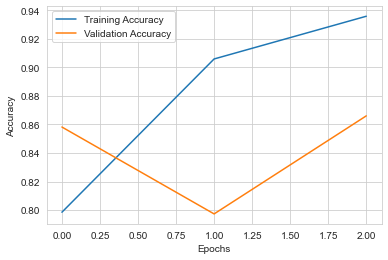

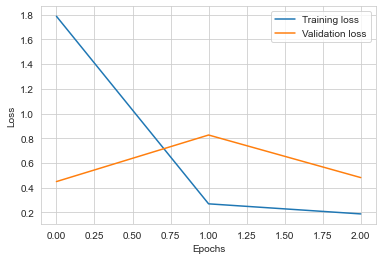

In [12]:
## Accuracy Graph
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(labels= ['Training Accuracy' , 'Validation Accuracy'])
sns.set_style('whitegrid')
plt.show()

## Loss Graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(labels= ['Training loss' , 'Validation loss'])
sns.set_style('whitegrid')
plt.show()

### Saving the Model

In [10]:
tf.keras.models.save_model(model , 'VGG16_model.hdf5')

### Mapping the Predictions

In [ ]:
img_names = os.listdir(test_dir)
model_predictions = []

for name in img_names:
    img = load_img(test_dir+name , target_size = (150,150))
    input_arr = img_to_array(img)
    input_arr_a = np.array([input_arr])  # Convert single image to a batch.
    model_predictions.append(model.predict(input_arr_a))
    
predictions = list()

for i in range(len(model_predictions)):
    if (0 == model_predictions[i].argmax()):
        predictions.append("buildings")
    elif (1 == model_predictions[i].argmax()):
        predictions.append("forest")
    elif (2 == model_predictions[i].argmax()):
        predictions.append("glacier")
    elif (3 == model_predictions[i].argmax()):
        predictions.append("mountain")
    elif (4 == model_predictions[i].argmax()):
        predictions.append("sea")
    elif (5 == model_predictions[i].argmax()):
        predictions.append("street")

### Creating Submission file of Predictions

In [ ]:
img_names = os.listdir(test_dir)
img_n_labels = list(zip(img_names , predictions))
submission_file = pd.DataFrame(img_n_labels,columns = ['Filename' , 'Labels'])
submission_file.to_csv('Submission File',index = False)